In [1]:
%matplotlib inline

In [2]:
from itertools import chain, combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from scripts.v_02.pdf_parser_class import PDFparser
import scripts.v_02.get_table_utils as tbu

In [3]:
PDF = "../../task_description/examples/GFS 5760519.pdf"

![PDF](gfs_5760519_page_1.png)
![PDF](gfs_5760519_page_2.png)

## Распознание структуры документа

In [4]:
my_parser = PDFparser()
df = my_parser.get_rows_marked(PDF)

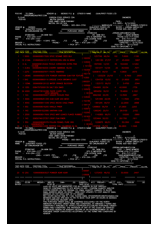

In [5]:
mrgn = 50
font_scale = .35
thickness = 1
font = cv2.FONT_HERSHEY_SIMPLEX
line_type = cv2.LINE_AA
    
longest_str = df.loc[df[0].str.len().idxmax()][0]

(w, h), baseline = cv2.getTextSize(longest_str,
                                   font,
                                   font_scale,
                                   thickness)

line_height = h + baseline

image = np.zeros((len(df) * line_height + mrgn * 2,
                  w + mrgn * 2,
                  3), dtype="uint8")

x, y0 = (mrgn, mrgn)
for r in range(len(df)):
    line = df.loc[r, 0]
    y = y0 + r * line_height
    if df.loc[r, "mark"] == "tbl_row":
        cv2.putText(image,
                    line,
                    (x, y),
                    font,
                    font_scale,
                    (255, 0, 0),
                    thickness,
                    line_type)
    elif df.loc[r, "mark"] == "tbl_hdr":
        cv2.putText(image,
                    line,
                    (x, y),
                    font,
                    font_scale,
                    (255, 255, 0),
                    thickness,
                    line_type)
    else:
        cv2.putText(image,
                    line,
                    (x, y),
                    font,
                    font_scale,
                    (255, 255, 255),
                    thickness,
                    line_type)
plt.axis("off")
plt.imshow(image)

## Выделение таблицы

In [6]:
table_strings = df.loc[df["mark"] == "tbl_row", 0]

в т.ч. "полные" строки

In [7]:
odd_strings = table_strings.iloc[::2]
odd_strings

22       1    1 500G    00066958017026 SPICE SESAME ...
24       2   12 212ML   01899500212117 PEPPERCORN GR...
26       3    6 2L      00066958145422 PICKLE CORNIC...
28       4    1 3.3KG   00066958150334 CHERRY AMAREN...
30       5    1 227G    00084909007971 PASTE TAMARIN...
32       6    1 280MG   00066958251376 POWDER XANTHA...
34       7    1 5KG     00066958800116 DREDGE CHICK ...
36       8    1 125ML   00066958120122 WATER ORANGE ...
38       9    6 125G    00847972000139 SALT SEA SMKD...
40      10   24 400G    40044738102382 PASTE CURRY Y...
42      11    1 1KG     00066958030407 GINGER PICKLE...
44      12    1 300G    00066958251345 GUM GUAR 200 ...
46      13    1 454G    00066958411046 SPICE ANCHO C...
48      14    1 55G     00066958016265 VANILLA PWDR ...
50      15    1 1KG     00069581522080 XANTHAN GUM  ...
52      16    1 250G    00066958017606 SPICE MINT LE...
54      17    1 1KG     00650746137357 CRISP FILM PW...
56      18    1 35G     00066958065379 POLLEN FE

в т.ч. "висячие" строки

In [8]:
evn_strings = table_strings.iloc[1::2] # "висячие" строки
evn_strings

23                                                  ...
25                                                  ...
27                      101308                      ...
29                                                  ...
31                                                  ...
33                                                  ...
35                                                  ...
37                                                  ...
39                                                  ...
41                                     GFSO 9854956 ...
43                                                  ...
45                                                  ...
47                                                  ...
49                                                  ...
51                                                  ...
53                                                  ...
55                                                  ...
57                      66958065379             

### Получение основной таблицы (из "полных" строк)
На будущее - этот и послед. преобразования упаковать в единый метод класса

In [9]:
odd_df = tbu.get_table(odd_strings)
odd_df

,0,1,2,3,4,5,6,7,8,9
22,1,1,500G,00066958017026,SPICE SESAME SEED BLK,1257749,96/04,192,7.0000,.1108
24,2,12,212ML,01899500212117,PEPPERCORN GRN IN BRINE,1281180,27/07,27,45.0000,.5867
26,3,6,2L,00066958145422,PICKLE CORNICHON EXTRA FINE,1307496,12/03,36,59.6400,3.1264
28,4,1,3.3KG,00066958150334,CHERRY AMARENA 18/20,1331077,10/04,20,46.5000,.7071
30,5,1,227G,00084909007971,PASTE TAMARIND,5290816,99/01,99,4.0600,.0573
32,6,1,280MG,00066958251376,POWDER XANTHAN GUM FOR TEXTURE,1253239,20/05,1,8.7600,.0554
34,7,1,5KG,00066958800116,DREDGE CHICK BROWN'S CUST,1354729,10/02,10,21.9500,.9651
36,8,1,125ML,00066958120122,WATER ORANGE BLOSSOM,1323173,99/01,3,3.4700,.0344
38,9,6,125G,00847972000139,SALT SEA SMKD,1344865,20/04,4,42.0000,.1739
40,10,24,400G,40044738102382,PASTE CURRY YEL,9854956,30/01,2,78.4800,2.1021


### Обработка "висячих" строк
1. Определяем относительные позиции текста из в ячейки таблицы в соответствующей исходной строке. Нужны, чтобы отнести "висячие" строки (по началу текста в строке)  к одной из сформированных колонок  

In [10]:
def get_cell_text_start_positions(row_orig, row_cell):
    pos_list = []
    start_pos = 0
    for cell_text in row_cell:
        row_orig_cutted = row_orig[start_pos:]
        cur_pos = row_orig_cutted.find(cell_text)
        pos_list.append(cur_pos + start_pos)
        start_pos += cur_pos + len(cell_text)
    return pos_list

cell_text_positions = []
for g, odd_s in enumerate(odd_strings):
    (cell_text_positions
    .append(get_cell_text_start_positions(odd_s,
                                          odd_df.iloc[g])))
    
cell_text_positions    

[[3, 8, 10, 18, 33, 79, 88, 98, 106, 118],
 [3, 7, 10, 18, 33, 79, 88, 99, 105, 118],
 [3, 8, 10, 18, 33, 79, 88, 99, 105, 117],
 [3, 8, 10, 18, 33, 79, 88, 99, 105, 118],
 [3, 8, 10, 18, 33, 79, 88, 99, 106, 118],
 [3, 8, 10, 18, 33, 79, 88, 100, 106, 118],
 [3, 8, 10, 18, 33, 79, 88, 99, 105, 118],
 [3, 8, 10, 18, 33, 79, 88, 100, 106, 118],
 [3, 8, 10, 18, 33, 79, 88, 100, 105, 118],
 [2, 7, 10, 18, 33, 79, 88, 100, 105, 117],
 [2, 8, 10, 18, 33, 79, 88, 100, 105, 118],
 [2, 8, 10, 18, 33, 79, 88, 100, 105, 118],
 [2, 8, 10, 18, 33, 79, 88, 100, 105, 118],
 [2, 8, 10, 18, 33, 79, 88, 100, 105, 118],
 [2, 8, 10, 18, 33, 79, 88, 100, 105, 118],
 [2, 8, 10, 18, 33, 79, 88, 100, 106, 118],
 [2, 8, 10, 18, 33, 79, 88, 100, 105, 118],
 [2, 8, 10, 18, 33, 79, 88, 100, 105, 118],
 [2, 8, 10, 18, 33, 79, 88, 100, 105, 117],
 [2, 7, 10, 18, 33, 79, 88, 100, 105, 118]]

Вспомогательная функция для переименования/преобразования индексов в строки (они же - колонки) таблицы 

In [11]:
def add_postfix(in_list):
    out_list = []
    i = 0
    while i < len(in_list) - 1:
        if in_list[i] != in_list[i + 1]:
            out_list.append(str(in_list[i]))
            i += 1
        j = 1
        while i + j < len(in_list):
            if in_list[i] == in_list[i + j]:
                out_list.append("{}_{}".format(in_list[i - 1], j))
                j += 1
            else:
                out_list.append(str(in_list[j]))
                break
        i += j
    out_list.append(str(in_list[-1]))
    return out_list

print("[4, 5, 5, 5, 6] ->", add_postfix([4, 5, 5, 5, 6]))

[4, 5, 5, 5, 6] -> ['4', '4_1', '4_2', '5', '6']


2. Соотносим элементы "висячих" строк (по позициям в строке) с колонками отработанной таблицы и формируем доп. таблицу с индексами строк как в основной

In [12]:
evn_cells_positions = []
for k, r in enumerate(evn_strings):
    row_mod = r.replace("|", " ").strip()
    row_spl = row_mod.split()
    text_pos = get_cell_text_start_positions(r, row_spl)
    col_idx = np.searchsorted(cell_text_positions[k], text_pos)
    col_idx_renamed = add_postfix(col_idx)

    one_row_df = pd.DataFrame(data=dict(zip(col_idx_renamed, row_spl)),
                              index=[odd_strings.index[k]])
    evn_cells_positions.append(one_row_df)

evn_df = pd.concat(evn_cells_positions, sort=True)
evn_df

,3,4,4_1,5
22,NaN,NaN,NaN,182050
24,NaN,NaN,NaN,103000
26,101308,NaN,NaN,101308
28,NaN,NaN,NaN,150359
30,NaN,NaN,NaN,182118
32,NaN,NaN,NaN,10300
34,NaN,NaN,NaN,800201
36,NaN,NaN,NaN,183699
38,NaN,NaN,NaN,183639
40,NaN,GFSO,9854956,181839


3. Объединяем колонки доп. таблицы с элементами, относенными к "промежуточным" колонкам 

In [13]:
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))

combos = []
for t in powerset(evn_df.columns):
    if len(t) > 1 and all(elem[0] == t[0][0] for elem in t):
        combos.append(list(t))

for combo in combos:
    evn_df[combo[0]] = evn_df[combo[0]].str.cat(evn_df[combo[1:]], sep=" ")
    evn_df.drop(combo[1:],
                axis=1,
                inplace=True)
    
evn_df

,3,4,5
22,NaN,NaN,182050
24,NaN,NaN,103000
26,101308,NaN,101308
28,NaN,NaN,150359
30,NaN,NaN,182118
32,NaN,NaN,10300
34,NaN,NaN,800201
36,NaN,NaN,183699
38,NaN,NaN,183639
40,NaN,GFSO 9854956,181839


4. Объединяем осн. и доп. таблицы, преобразуем индексы колонок и строк

In [14]:
full_table = pd.concat([odd_df, evn_df], axis=1, sort=True)

full_table.columns = full_table.columns.astype(str)
full_table.sort_index(axis=1, inplace=True)
full_table.columns = list(range(full_table.shape[1]))

full_table = full_table.reset_index(drop=True)
full_table

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,1,500G,00066958017026,NaN,SPICE SESAME SEED BLK,NaN,1257749,182050,96/04,192,7.0000,.1108
1,2,12,212ML,01899500212117,NaN,PEPPERCORN GRN IN BRINE,NaN,1281180,103000,27/07,27,45.0000,.5867
2,3,6,2L,00066958145422,101308,PICKLE CORNICHON EXTRA FINE,NaN,1307496,101308,12/03,36,59.6400,3.1264
3,4,1,3.3KG,00066958150334,NaN,CHERRY AMARENA 18/20,NaN,1331077,150359,10/04,20,46.5000,.7071
4,5,1,227G,00084909007971,NaN,PASTE TAMARIND,NaN,5290816,182118,99/01,99,4.0600,.0573
5,6,1,280MG,00066958251376,NaN,POWDER XANTHAN GUM FOR TEXTURE,NaN,1253239,10300,20/05,1,8.7600,.0554
6,7,1,5KG,00066958800116,NaN,DREDGE CHICK BROWN'S CUST,NaN,1354729,800201,10/02,10,21.9500,.9651
7,8,1,125ML,00066958120122,NaN,WATER ORANGE BLOSSOM,NaN,1323173,183699,99/01,3,3.4700,.0344
8,9,6,125G,00847972000139,NaN,SALT SEA SMKD,NaN,1344865,183639,20/04,4,42.0000,.1739
9,10,24,400G,40044738102382,NaN,PASTE CURRY YEL,GFSO 9854956,9854956,181839,30/01,2,78.4800,2.1021
